In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from wordcloud import wordcloud
%matplotlib inline

In [2]:
#!pip install matplotlib wordcloud

wordcloud - there are words (genera of movies), frequnecy o

In [3]:
#### READING ANIMELIST.CSV

In [5]:
import os

In [6]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [7]:
rating_df = pd.read_csv(INPUT_DIR+ "/animelist.csv", low_memory=True,usecols=["user_id","anime_id","rating"])

In [8]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [9]:
rating_df.shape

(5000000, 3)

In [10]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 114.4 MB


#### DATA PROCESSING

Focus on active user (frequent) who have watched the anime in high frequency as they will help in our recommendation more efficiently 

In [11]:
n_rating = rating_df.user_id.value_counts()

In [12]:
n_rating # user_id 11100  has given 14429 number of ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
13465        1
16480        1
16465        1
3465         1
16450        1
Name: count, Length: 15186, dtype: int64

Remove infrequent users, keep on user who has rated more than 400 anime

In [13]:
rating_df = rating_df[rating_df["user_id"].isin(n_rating[n_rating >=400].index)].copy()

In [14]:
len(rating_df)

3246641

In [15]:
min_rating = min(rating_df['rating'])

In [16]:
max_rating = max(rating_df['rating'])

In [17]:
average_rating = np.mean(rating_df['rating'])

In [18]:
min_rating,max_rating,average_rating

(0, 10, np.float64(4.122732695114736))

MinMax Scaling Rating column

In [19]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x - min_rating)/(max_rating - min_rating)).values.astype(np.float64)

In [20]:
rating_df['rating'].max(), rating_df['rating'].mean()

(np.float64(1.0), np.float64(0.4122732695114736))

In [21]:
rating_df.duplicated().sum()

np.int64(0)

In [22]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

Extract all the unique userid into a list

In [23]:
users_ids = rating_df['user_id'].unique().tolist() 

In [24]:
user2user_encoded = {x: i for i,x in enumerate(users_ids)}

In [25]:
user2user_decoded = {i: x for i,x in enumerate(users_ids)}

In [26]:
#Mapping
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [27]:
rating_df.head(3)

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0


In [28]:
n_users = len(user2user_encoded)
n_users  # experienced/ frequent users

4203

Encoding and decoding anime_id

In [29]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x: i for i,x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i,x in enumerate(anime_ids)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded)

In [30]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In our dataset we have 4203 users and 17149 unique anime

########### shuffle data

In [31]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [32]:
X = rating_df[['user','anime']].values
y = rating_df['rating']

In [33]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [34]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

In [35]:
len(X_train), len(X_test)

(3245641, 1000)

In [36]:
type(X_train)

numpy.ndarray

2 separate arrays one for anime features an other for user features and then store them in a list

In [37]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [38]:
type(X_test_array)

list

In [39]:
type(X_test_array[0])

numpy.ndarray

#### MODEL ARCHITECTURE

In [40]:
def RecommenderNet():
    embedding_size = 128
    user = Input(name='user', shape=[1]) 

    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)
    
    anime = Input(name='anime', shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name='dot_product',normalize= True, axes=2)([user_embedding, anime_embedding]) # similarity b/w user embedding and anime embedding
    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x= BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs = [user,anime], outputs=x) # we made user and anime input different so that we can pass them as input

    model.compile(loss='binary_crossentropy', metrics=["mae","mse"], optimizer='Adam')

    return model

In [41]:
model  = RecommenderNet()

In [39]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [42]:
start_lr =0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000
ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr)/ ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr


In [43]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch),verbose=0)
checkpoint_filepath ='./weights.weights.h5' 

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                                   save_weights_only=True, monitor="val_loss",
                                   mode='min', save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min",
                               restore_best_weights=True )

In [44]:
mycallbacks =[model_checkpoint, lr_callback, early_stopping]

In [45]:
history = model.fit(x=X_train_array, y=y_train, batch_size= batch_size,
          epochs=20, verbose=1, validation_data = [X_test_array,y_test],
           callbacks = mycallbacks )

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - loss: 0.7995 - mae: 0.3820 - mse: 0.1970 - val_loss: 0.7228 - val_mae: 0.3643 - val_mse: 0.1691 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - loss: 0.7960 - mae: 0.3807 - mse: 0.1956 - val_loss: 0.7811 - val_mae: 0.3754 - val_mse: 0.1900 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - loss: 0.7901 - mae: 0.3785 - mse: 0.1933 - val_loss: 0.7857 - val_mae: 0.3762 - val_mse: 0.1913 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 0.7817 - mae: 0.3752 - mse: 0.1899 - val_loss: 0.7824 - val_mae: 0.3754 - val_mse: 0.1901 - learning_rate: 3.4000e-05


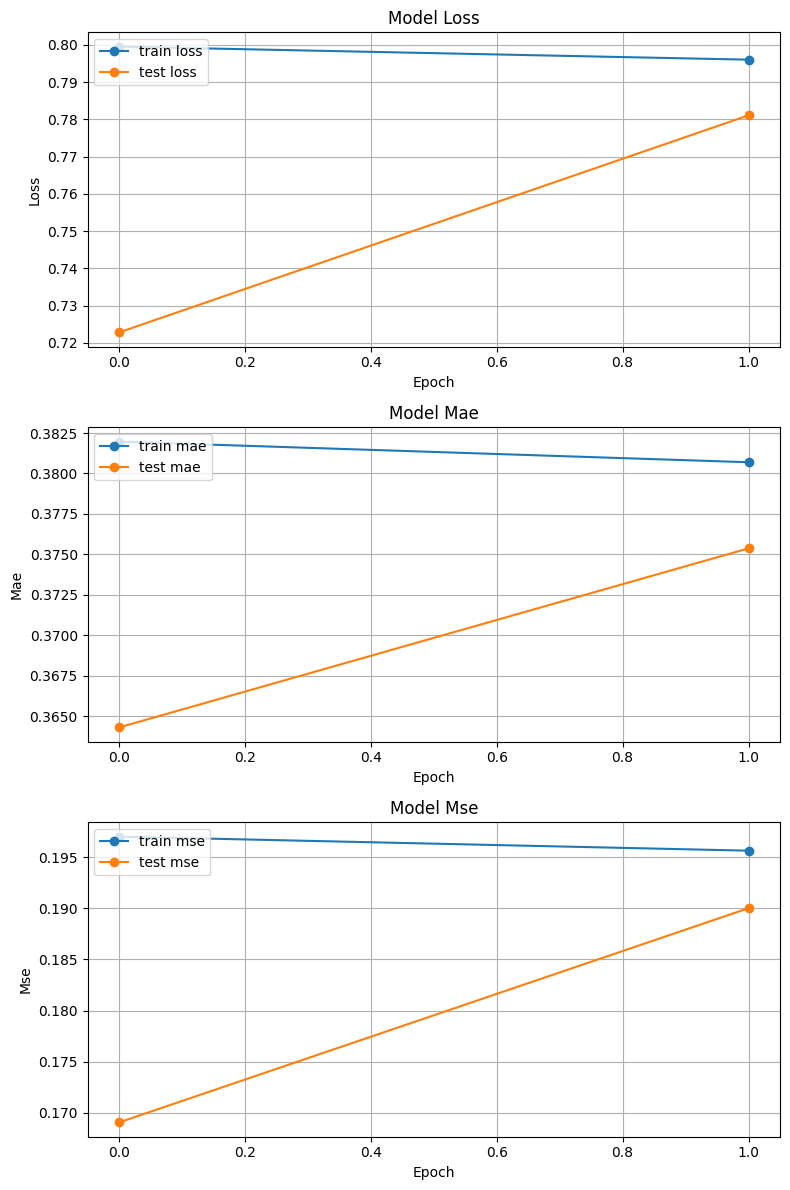

In [46]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

anime weights are stored in anime embedding and user weights are stored in user embedding, we have to extract that weight from anime embedding layer and user embedding layer

In [47]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/ np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [48]:
anime_weights = extract_weights("anime_embedding", model=model)

In [49]:
user_weights = extract_weights("user_embedding", model=model)

#### READING ANIME.CSV

MAL_ID = my anime list ID ; my anime list.net - data has been extracted from this website

In [50]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [51]:
df = df.replace("Unknown", np.nan)

In [52]:
# pass the anime id it will give the name of anime
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")

    return name     

In [53]:
df["anime_id"] = df.MAL_ID

In [54]:
df["English name"].unique()

array(['Cowboy Bebop', 'Cowboy Bebop:The Movie', 'Trigun', ...,
       'The Promised Neverland Season 2 Episode 5.5',
       'Immemorial Love For You 2nd Season',
       'Higurashi:When They Cry – SOTSU'], shape=(6831,), dtype=object)

In [55]:
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x: getAnimeName(x))

In [56]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie


In [57]:
getAnimeName(67)

'Basilisk'

In [58]:
getAnimeName(6702)

'Fairy Tail'

In [59]:
df.sort_values(by=['Score'], inplace=True, ascending=False,
               kind='quicksort', na_position='last' )

In [60]:
df[['Score', 'Name']].head(3)

,Score,Name
3971,9.19,Fullmetal Alchemist: Brotherhood
15926,9.17,Shingeki no Kyojin: The Final Season
5683,9.11,Steins;Gate


In [61]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [62]:
df = df[["anime_id", "eng_version","Score","Genres","Episodes","Type",
         "Members","Premiered"]]
df.head(2)

,anime_id,eng_version,Score,Genres,Episodes,Type,Members,Premiered
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,2248456,Spring 2009
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,733260,Winter 2021


In [63]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]


In [64]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Members,Premiered
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,733260,Winter 2021


In [65]:
getAnimeFrame("Trigun",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Members,Premiered
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",26,TV,558913,Spring 1998


#### ANIME_WITH_SYNOPSIS.CSV

In [66]:
cols =["MAL_ID", "Name","Genres","sypnopsis"]

In [67]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [68]:
synopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."


In [69]:
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime][0].sypnopsis.values[0]

In [70]:
getSynopsis(40028,df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

## CONTENT/ ITEM BASED RECOMMENDATION SYSTEM

In [71]:
pd.set_option("max_colwidth", None)

In [72]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


name- on which anime u want to pass recommendation (want similar recommendation), anime_weights (weights extracted from model), encoded and decoded of anime, n=10 number of recommendation u want, return_dist, neg=False (to find the most similar anime) if true will find the most dissimilar anime. 

In [ ]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    # here we will take the weight of nartu(anime) and compare it with the weight of all other anime 
    
    sorted_dists = np.argsort(dists) # least similar to most similar

    n = n + 1 # want the target anime to be included in the result

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:] # indexes of all similar anime will loop through it

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    # drop the input anime_id so that we dont get the anime we are searching to get similar anime
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

In [78]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df

)

,name,similarity,genre
9,Onami,0.335993,Music
8,Kuro Gal ni Natta kara Shinyuu to shitemita.,0.332342,"Romance, Shounen Ai"
7,Petit Petit Muse,0.314638,"Cars, Horror, Kids"
6,Lalala Lala-chan: Patapata Daisensou,0.313033,"Adventure, Fantasy, Kids"
5,Hong Gil Dong 2084,0.303253,"Action, Adventure"
4,Moonlight Sonata,0.300175,Hentai
3,RG Veda,0.298376,"Adventure, Drama, Fantasy"
2,School-Live!,0.298127,"Slice of Life, Psychological, School, Horror, Mystery"
1,Yoru no Hi,0.297095,Psychological
0,Shakugan no Shana: Friagne & Marianne no Naze Nani Shana! Nandemo Shitsumonbako! 2,0.292173,"Comedy, Supernatural, Fantasy"


## USER BASED RECOMMENDATION SYSTEM/ COLLABORATING FILTERING

In [ ]:
# FIND THE SIMILAR USER TO A GIVEN USER

def find_similar_users(item_input, user_weights, user2user_encoded, 
                       user2user_decoded,n=10, return_dist=False, neg=False ):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        weghts = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n =n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:] 

        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int): # user id is integer
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append()
        